# Comparison of arrival direction and joint models

In order to verify the model is working, we fit simulations made under the assumptions of the model. We also compare the differences between a model for only the UHECR arrival directions and one for both the UHECR arrival directions and energies.
<br>
<br>
*This code is used to produce the data shown in Figures 6, 7 and 8 (left panel) in Capel & Mortlock (2019).*  
*See the separate notebook in this directory for the actual plotting of figures.*

In [1]:
import numpy as np
import os
import h5py
from matplotlib import pyplot as plt
from pandas import DataFrame

from fancy import Data, Model, Analysis

In [2]:
# Define location of Stan files
stan_path = '../../stan/'

# Define file containing source catalogue information
source_type = 'swift_BAT_213'
# source_type = 'SBG_23'
# source_type = "2FHL_250Mpc"
source_file = '../../data/sourcedata.h5'
table_file = '../../data/tables_{0}_PAO.h5'.format(source_type)

# make output directory if it doesnt exist
if not os.path.isdir("output"):
    os.mkdir("output")

# Define output files
sim_output_file = 'output/joint_model_simulation_{0}_PAO.h5'.format(source_type)
arrival_output_file = 'output/arrival_direction_fit_{0}_PAO.h5'.format(source_type)
joint_output_file = 'output/joint_fit_{0}_PAO.h5'.format(source_type)

# Define random seed to match paper results
# random_seed = 1992071502
random_seed = 19990308

## Simulation

Set up a simulation using randomly selected sources and the Pierre Auger Observatory as a detector. This simulation will include all the processes described in Section 2 of the paper. 

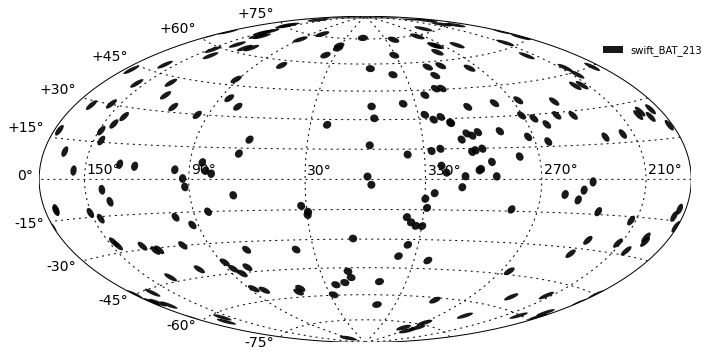

In [3]:
from fancy.detector.auger2014 import detector_properties, alpha_T, M
# from fancy.detector.TA2015 import detector_properties, alpha_T, M

# Define a source catalogue and detector exposure
# In the paper we use the SBG catalogue
data = Data()
data.add_source(source_file, source_type)
data.add_detector(detector_properties)

# Plot the sources in Galactic coordinates
data.show();

In [4]:
# Define a Stan simulation to run
sim_name = stan_path + 'joint_model_sim.stan' # simulate all processes

# Define simulation using Model object and compile Stan code if necessary
simulation = Model(sim_filename = sim_name, include_paths = stan_path)
simulation.compile(reset=False)

Using cached StanModel


In [5]:
from fancy.interfaces.stan import get_simulation_input

# Define associated fraction
f = 0.5 

# Simulation input
B = 20 # nG
alpha = 3.0
Eth = 52 # EeV
# Eth = 57   # EeV, for TA
Eth_sim = 20 # EeV

# number of simulated inputs
# changes the background flux linearly
# should change this based on the approx. # events you would expect
# from each experiment
# a bit weird in my opinion
Nsim = 2500  # for PAO


# L in yr^-1, F in km^-2 yr^-1
L, F0 = get_simulation_input(Nsim, f, data.source.distance, M, alpha_T)

# To scale between definition of flux in simulations and fits
flux_scale = (Eth / Eth_sim)**(1 - alpha)

simulation.input(B = B, L = L, F0 = F0,
            alpha = alpha, Eth = Eth)

In [6]:
print(L, F0)

[8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.63778056e+39 8.63778056e+39 8.63778056e+39
 8.63778056e+39 8.637780

In [7]:
# What is happening 
summary = b'Simulation using the joint model and SBG catalogue' # must be a byte str
# summary = b'Simulation using the joint model and Swift-BAT catalogue' # must be a byte str
    
# Define an Analysis object to bring together Data and Model objects
sim_analysis = Analysis(data, simulation, analysis_type = 'joint', 
                    filename = sim_output_file, summary = summary)

In [8]:
# Build pre-computed values for the simulation as you go
# So that you can try out different parameters
sim_analysis.build_tables(sim_only = True)

Precomputing exposure integral: 100%|██████████| 213/213 [03:00<00:00,  1.18it/s]

In [9]:
# Run simulation
sim_analysis.simulate(seed = random_seed, Eth_sim = Eth_sim)

# Save to file 
sim_analysis.save()

Running Stan simulation...
Extracting output...
Simulating zenith angles...
Done!


In [10]:
len(sim_analysis.source_labels)

286

### Visualise simulation results
Some simple functions are built in to allow quick visualisation of the simulation results. The arrival directions of the UHECRs are shown colour coded by the source component they come from, including the background component. The energy spectrum of the UHECRs is also shown, including the difference between $\tilde{E}$, $E$ and $\hat{E}$. 

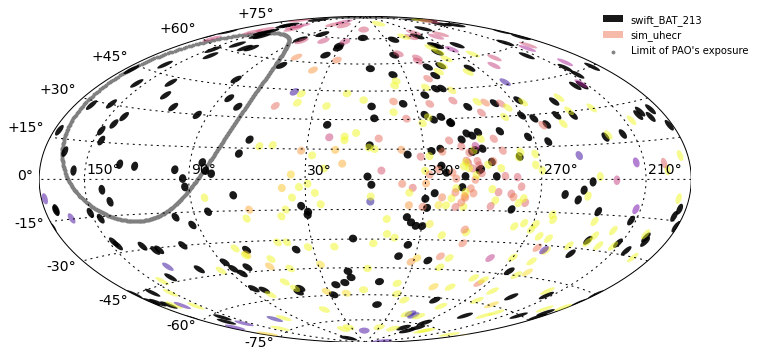

In [11]:
sim_analysis.plot('arrival direction')

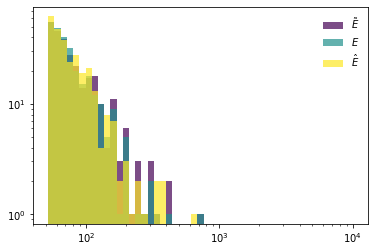

In [12]:
sim_analysis.plot('energy')

## Fit the arrival direction model

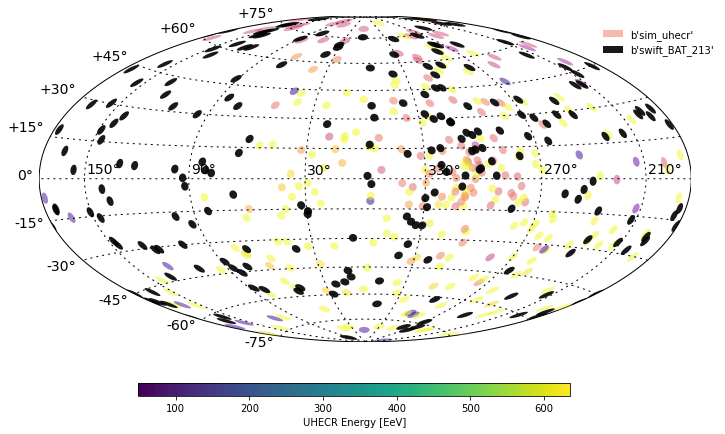

In [13]:
# Define data from simulation
data = Data()
data.from_file(sim_output_file)
data.show();

In [14]:
# Arrival direction model
model_name = stan_path + 'arrival_direction_model.stan'

# Compile
model = Model(model_filename = model_name, include_paths = stan_path)
model.compile(reset=False)

# Define threshold energy in EeV
Eth = 52  # for PAO
# Eth = 57    # for TA
model.input(Eth = Eth)

Using cached StanModel


In [15]:
# What is happening 
summary = b'Fit of the arrival direction model to the joint simulation' 
    
# Define an Analysis object to bring together Data and Model objects
analysis = Analysis(data, model, analysis_type = 'joint', 
                    filename = arrival_output_file, summary = summary)

In [16]:
# Define location of pre-computed values used in fits 
# (see relevant notebook for how to make these files) 
# Each catalogue has a file of pre-computed values
analysis.use_tables(table_file)

In [17]:
# Fit the Stan model
# fit = analysis.fit_model(chains = 4, iterations = 2000, seed = random_seed)

# # Save to analysis file
# analysis.save()

In [18]:
# Fit the Stan model
fit = analysis.fit_model(chains = 16, iterations = 500, seed = random_seed)

# Save to analysis file
analysis.save()

## Fit the joint model

This proceeds exactly as above, just changing the Stan model and output filename. 

In [19]:
data = Data()
data.from_file(sim_output_file)

model_name = stan_path + 'joint_model.stan'
model = Model(model_filename = model_name, include_paths = stan_path)
model.compile(reset=False)
model.input(Eth = Eth)

summary = b'Fit of the joint model to the joint simulation' 
analysis = Analysis(data, model, analysis_type = 'joint', 
                    filename = joint_output_file, summary = summary)
analysis.use_tables(table_file)

Using cached StanModel


In [20]:
# fit = analysis.fit_model(chains = 4, iterations = 2000, seed = random_seed)
# analysis.save()
# NB: can ignore warnings for lambda, this is just a generated quantity and not a sampled parameter.

In [21]:
fit = analysis.fit_model(chains = 28, iterations = 400, seed = random_seed)
analysis.save()
# NB: can ignore warnings for lambda, this is just a generated quantity and not a sampled parameter.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
